In [1]:
import numpy as np
from glob import glob

import torch
import matplotlib.pyplot as plt
%matplotlib inline

from src.datasets import Pretrained_Dset, unpickle, lab_dict
from src.models import PretrainedModel
from src.trainers import plot_features

seed = 147
np.random.seed(seed)
torch.manual_seed(seed)

# 1. Dataset

#### Cifar-10

```bash
wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz -C DATA/
```

## 1.1 Train

In [2]:
images = np.array([], dtype=np.uint8).reshape((0, 3072))
labels = np.array([])

for file in glob("DATA/train_batch_*"):
    data_dict = unpickle(file)

    images = np.append(images, data_dict[b'data'], axis=0)
    labels = np.append(labels,data_dict[b'labels'])

images = images.reshape((-1,3,32,32)).astype(np.float)

print(f"{images.shape = }")
print(f"{labels.shape = }")

images.shape = (50000, 3, 32, 32)
labels.shape = (50000,)


In [3]:
train_images, val_images = images[:40000], images[40000:]
train_labels, val_labels = labels[:40000], labels[40000:]

print(f"{train_images.shape = }, {val_images.shape = }")

train_images.shape = (40000, 3, 32, 32), val_images.shape = (10000, 3, 32, 32)


#### Extract mean and std

In [4]:
MEAN = np.mean(train_images/255.0, axis=(0,2,3), keepdims=True)
STD = np.std(train_images/255.0, axis=(0,2,3), keepdims=True)

print(f"{MEAN.shape = }, {MEAN = }")
print(f"{STD.shape = }, {STD = }")

MEAN.shape = (1, 3, 1, 1), MEAN = array([[[[0.49147004]],

        [[0.48210773]],

        [[0.44648033]]]])
STD.shape = (1, 3, 1, 1), STD = array([[[[0.24729047]],

        [[0.24369064]],

        [[0.26166811]]]])


## 1.2 Test

In [5]:
test_images = np.array([], dtype=np.uint8).reshape((0,3072))
test_labels = np.array([])

data_dict = unpickle('DATA/test_batch')
test_images = np.append(test_images, data_dict[b'data'],axis=0)
test_labels = np.append(test_labels,  data_dict[b'labels'])

test_images = test_images.reshape((-1,3,32,32)).astype(np.float)

print(f"{test_images.shape = }")
print(f"{test_labels.shape = }")

test_images.shape = (10000, 3, 32, 32)
test_labels.shape = (10000,)


# 2. Pretrain

## 2.1 Datasets

In [6]:
train_dset = Pretrained_Dset(train_images, train_labels,
    mode='train',
    mean=MEAN, std=STD)
val_dset = Pretrained_Dset(val_images, val_labels,
    mode='valid',
    mean=MEAN, std=STD)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label = 'horse'


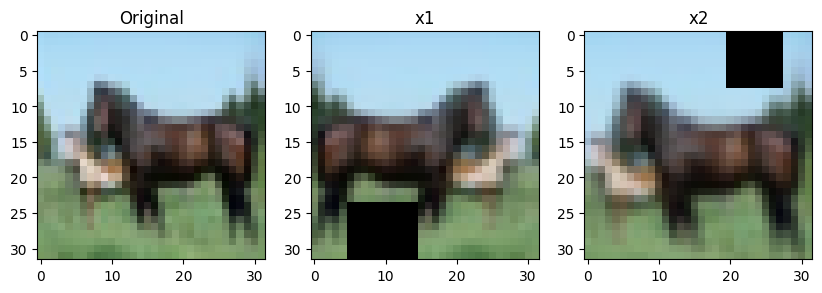

In [7]:
idx = 12
MEAN = torch.tensor(MEAN).float().squeeze(dim=0)
STD = torch.tensor(STD).float().squeeze(dim=0)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 24))

np_img = (train_dset[idx]['img']*STD + MEAN) \
    .permute(1, 2, 0).numpy()
axes[0].imshow(np_img);
axes[0].set_title('Original')

np_img = (train_dset[idx]['x1']*STD + MEAN) \
    .permute(1, 2, 0).numpy()
axes[1].imshow(np_img);
axes[1].set_title('x1')

np_img = (train_dset[idx]['x2']*STD + MEAN) \
    .permute(1, 2, 0).numpy()
axes[2].imshow(np_img);
axes[2].set_title('x2')

label = lab_dict[train_dset[idx]['label'].item()]
print(f"{label = }")
plt.show()

## 2.3 Pretrain

In [8]:
def plot_pretrained_feats(exp_name, device='cuda:0'):
    premodel = PretrainedModel().to(device)
    premodel.load_state_dict(torch.load(
        f'exp/{exp_name}/chkpts/best_pretrained.pt')['model'])

    plot_features(premodel.pretrained, val_dset, lab_dict)

Plotting TSNE: 100%|██████████| 312/312 [00:05<00:00, 61.58it/s] 


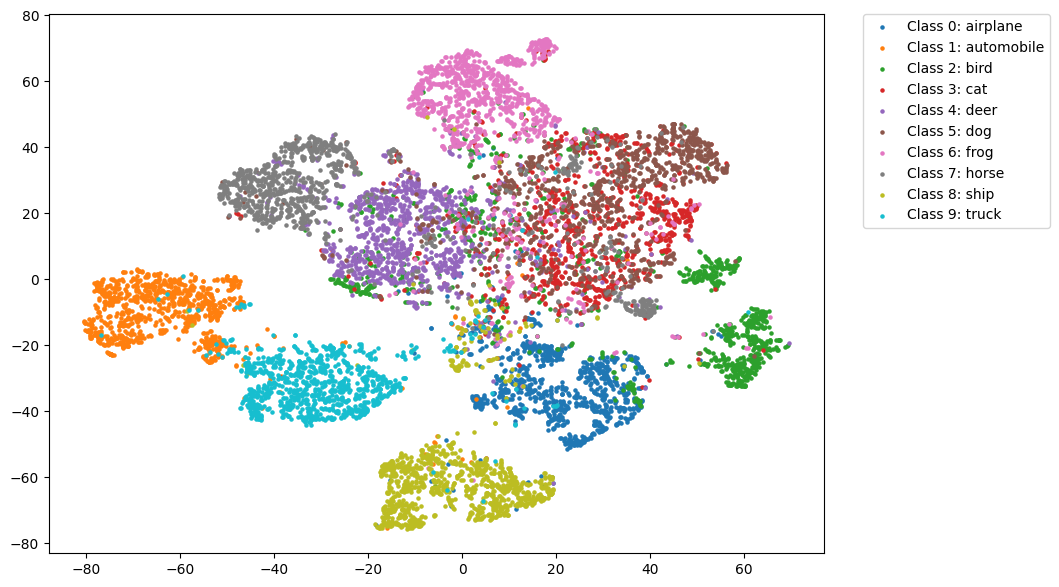

In [9]:
plot_pretrained_feats('SimCLR');

Plotting TSNE: 100%|██████████| 312/312 [00:05<00:00, 60.11it/s]


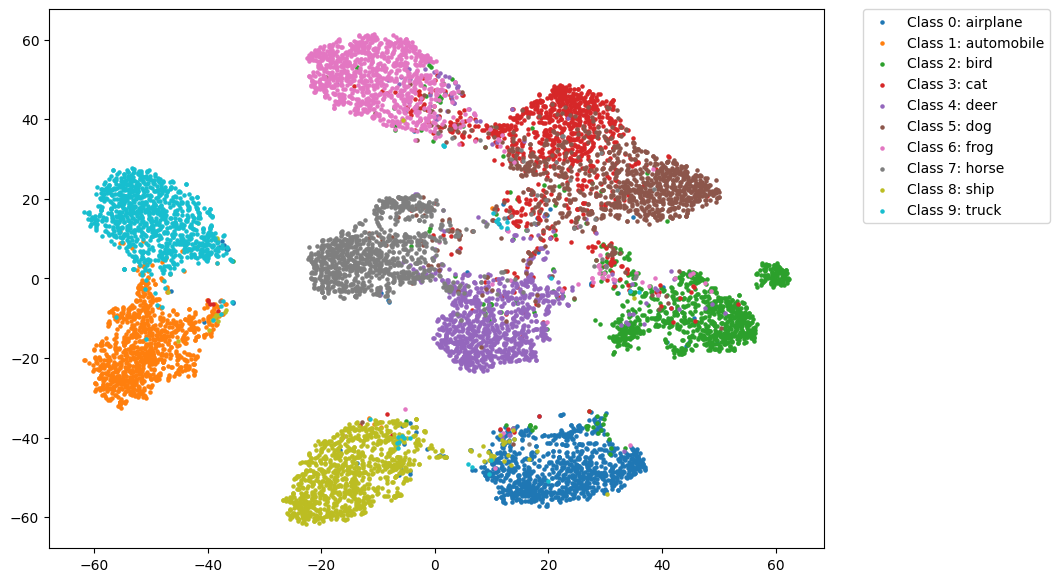

In [10]:
plot_pretrained_feats('SupCon');

Plotting TSNE: 100%|██████████| 312/312 [00:04<00:00, 66.19it/s]


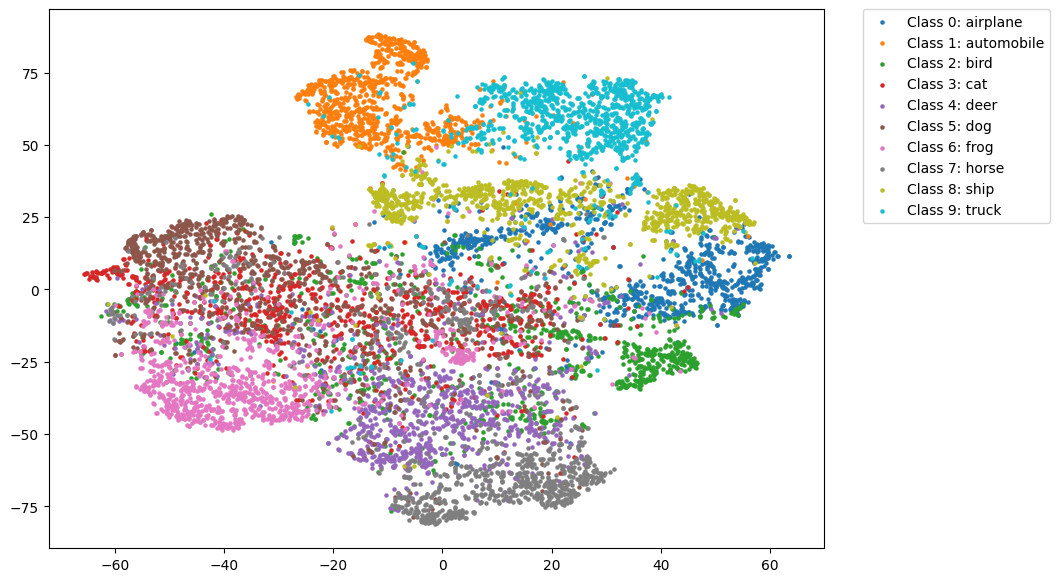

In [11]:
plot_pretrained_feats('SupCon_simclr');

# 3. Finetune

In [12]:
for file in sorted(glob("exp/*/test_stats.txt"), reverse=True):
    exp_name = file.split('/')[-2]
    accuracy = float(open(file).readline().split()[-1])
    print(f"{exp_name}: {accuracy*100.0:.3f}%")

baseline: 42.200%
SupCon_simclr: 80.100%
SupCon: 88.420%
SimCLR: 83.650%
